In [1]:
import copy
import sys

import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F

sys.path.append('..')

from src.agents import RainbowAgent, EzExplorerAgent, SurprisalExplorerAgent
from src.agents import SFPredictor
from src.agents.Rainbow import DEFAULT_RAINBOW_ARGS
from src.envs import *
from src.training import *
from src.models import *

%matplotlib inline

In [2]:
env = create_simple_gridworld_env(True, 100)
# env = create_crazy_climber_env()

In [3]:
custom_encoder = None
if env.observation_space.shape[1] <= 42:
  custom_encoder = create_gridworld_convs(env.observation_space.shape[0])

In [5]:
embed_dim = 256
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rainbow_args = copy.copy(DEFAULT_RAINBOW_ARGS)
rainbow_args.device = device
# rainbow_args.replay_frequency = 8

sf_model = SFNetwork(list(env.observation_space.shape), embed_dim)
sf_model = sf_model.to(device)
repr_learner = SFPredictor(
    sf_model,
    batch_size = 32,
    update_freq = 16,
    log_freq = 200,
    target_net_update_freq = 64,
    discount_factor = 0.99,
    lr = 1e-4)

In [6]:
policy_net = PolicyNetwork(list(env.observation_space.shape), env.action_space.n)
policy_net = policy_net.to(device)
critic_net = CriticNetwork(list(env.observation_space.shape))
critic_net = critic_net.to(device)

explore_agent = SurprisalExplorerAgent(
    env, policy_net, critic_net, repr_learner, log_freq=50,
    update_freq=2000, batch_size=400, epsilon=0.1, gamma=0.97)
# train_exploration_model(explore_agent, env, int(1e6))
train_task_model(explore_agent, env, int(1e6), print_rewards=True)

e:\projects\rl_representation_learning\src\agents\exploration.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=self.device)
e:\projects\rl_representation_learning\src\agents\base.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.stack([torch.tensor(se, dtype=torch.float32) for se in e], \
e:\projects\rl_representation_learning\src\agents\exploration.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_data = [torch.tensor(e, dtype=torch.float32) \
e:\projects\rl_rep

Step: 5000 | Episodes: 55 | Ep rewards: -88.0545
Step: 10000 | Episodes: 56 | Ep rewards: -89.3571
Step: 15000 | Episodes: 51 | Ep rewards: -96.0000
Step: 20000 | Episodes: 52 | Ep rewards: -94.7500
Step: 25000 | Episodes: 53 | Ep rewards: -93.3774
Step: 30000 | Episodes: 54 | Ep rewards: -91.6296
Step: 35000 | Episodes: 54 | Ep rewards: -92.7963
Step: 40000 | Episodes: 52 | Ep rewards: -94.2885
Step: 45000 | Episodes: 56 | Ep rewards: -88.7679
Step: 50000 | Episodes: 53 | Ep rewards: -91.8302
Step: 55000 | Episodes: 57 | Ep rewards: -87.3333
Step: 60000 | Episodes: 53 | Ep rewards: -92.3585
Step: 65000 | Episodes: 54 | Ep rewards: -93.1296
Step: 70000 | Episodes: 60 | Ep rewards: -81.8000
Step: 75000 | Episodes: 53 | Ep rewards: -92.7358
Step: 80000 | Episodes: 53 | Ep rewards: -92.4906
Step: 85000 | Episodes: 52 | Ep rewards: -95.3077
Step: 90000 | Episodes: 54 | Ep rewards: -92.3333
Step: 95000 | Episodes: 52 | Ep rewards: -94.6923
Step: 100000 | Episodes: 58 | Ep rewards: -85.4655


KeyboardInterrupt: 

In [ ]:
a = torch.stack(explore_agent.reward_normalizer.hist)
print(len(a))
print(a.shape)
print(a.mean())
print(a.std())

b = (a - a.mean()) / a.std()
print(len(b))
print(b.shape)
print(b.mean())
print(b.std())
print(min(b), max(b))


100000
torch.Size([100000])
tensor(0.0018)
tensor(0.0429)
100000
torch.Size([100000])
tensor(-3.0518e-10)
tensor(1.0000)
tensor(-0.0429) tensor(23.2910)


[[-30.44734955 -29.28945923 -31.84606552 -29.58033943]
 [-29.9898777    0.           0.           0.        ]]


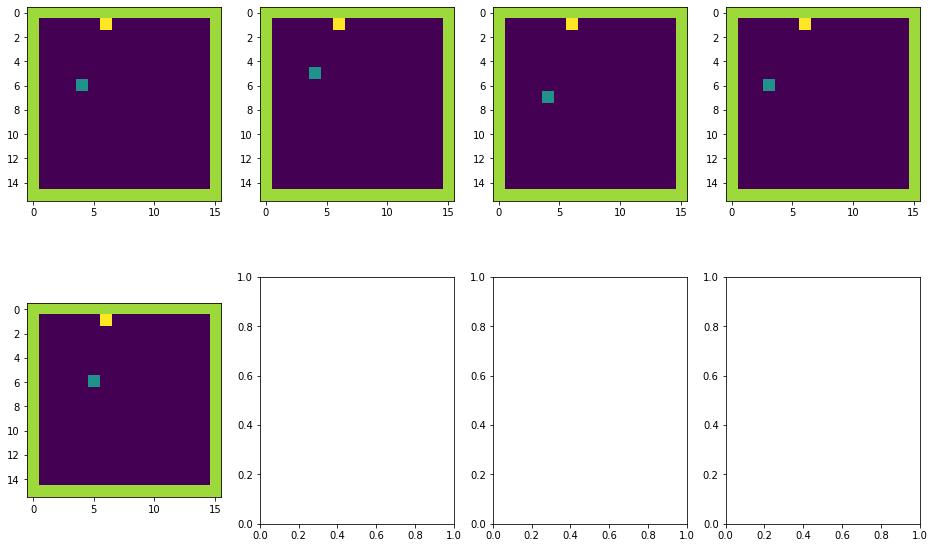

In [ ]:
# Create a subplot with 4 rows and 1 column
fig, axs = plt.subplots(int(np.ceil(env.action_space.n / 4)), 4, figsize=(16, 10))
values = np.zeros((axs.shape[0], axs.shape[1],))

obs = env.reset()
avg_obs = torch.zeros_like(obs)
for act in range(env.action_space.n):
    cenv = copy.deepcopy(env)
    obs, _, _, _ = cenv.step(act)
    avg_obs += obs
    axs[act//4, act%4].imshow(obs[0])
    values[act//4, act%4] = critic_net(obs[None].to(device)).squeeze().item()

print(np.array(values).reshape(*axs.shape))

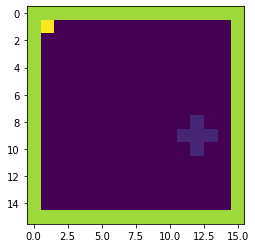

In [ ]:
plt.imshow(avg_obs[0] / env.action_space.n)

In [6]:
encoder_copy = copy.deepcopy(sf_model.encoder)
encoder_copy = encoder_copy.to('cpu')

agent = RainbowAgent(env, rainbow_args, encoder_copy, repr_learner=None)
sf_model = sf_model.to(device)

In [7]:
train_task_model(agent, env, int(1e5))

Step: 5000	# Episodes: 52	Avg ep reward: 0.06
Step: 10000	# Episodes: 56	Avg ep reward: 0.16
Step: 15000	# Episodes: 52	Avg ep reward: 0.12
Step: 20000	# Episodes: 53	Avg ep reward: 0.08
Step: 25000	# Episodes: 53	Avg ep reward: 0.09


KeyboardInterrupt: 